Best Alpha: 0.05
Best Max Iterations: 5000
Corresponding Mean Squared Error: 0.0139163287600764
Corresponding R-squared: 0.7376334720416307

Coefficients for the Best Alpha and Max Iterations:
seats: 0.0
sq_cabinet: -0.0
sq_pm: 0.0
base: 0.0
miw_new: -0.0
banzhaf: 0.0822076626840518
total_cabinet_size: -0.0
party_count: -0.0
cab_count: -0.02172448524100773
seats_share: 0.0
enpp: -0.0
seats_total: 0.0
miw_proportion: 0.0
seats_proportion: 0.059875221962452235
W: 0.0

Selected Features for the Best Alpha and Max Iterations:
['banzhaf', 'seats_proportion', 'cab_count', 'seats']


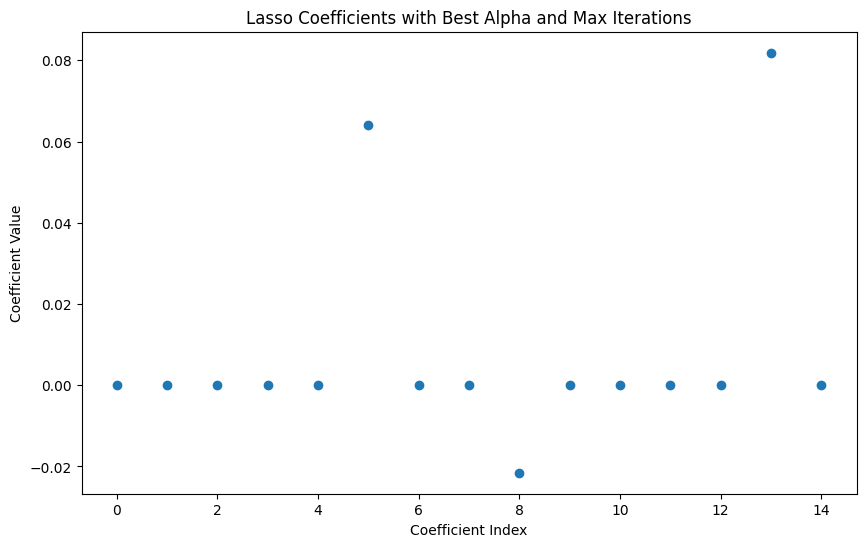

In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import warnings

df = pd.read_csv('class_final_proportion.csv')
row_index_to_drop = 6
df = df.drop(df.index[row_index_to_drop])
df.dropna(inplace=True)

#columns_to_drop = ['country', 'party', 'cabinet_name','cabinet_seats','cabinet_proportion', 'party_name', 'party_name_english', 'base','election_date', 'start_date']
columns_to_drop = ['cabinet_proportion','party', 'election_year','country', 'cabinet_name','caretaker','cabinet_id','party_id','prime_minister','cabinet_party','left_righty','left_rightx','cabinet_seats','party_name','party_name_english','country_id','election_id','election_date','start_date','post_election','mingov','bicameral','largest_parl','largest_cab','lag_largest_parl','lag_largest_cab','A', 'B','B_star','C','D','E','country_dummy1','country_dummy2','country_dummy3','country_dummy4','country_dummy5','country_dummy6','country_dummy7','country_dummy8','country_dummy9','country_dummy10','country_dummy11','country_dummy12','country_dummy13','coalition_total']

#pca1 = ['shapley', 'splus'] # banzhaf
X = df.drop(columns=columns_to_drop + pca1)
y = df['cabinet_proportion']


# Impute missing values with knn
#imputer = KNNImputer(n_neighbors=10)
#X_imputed = imputer.fit_transform(X)

# standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# set up k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True)

# define a range of alpha values and max_iter values to try
alphas = [.05, 0.1, 0.5, 1.0, 5.0, 10.0]
max_iters = [100, 500, 1000, 5000, 10000]

#store results for each alpha and max_iter combination
results = {}

#store coefficients for each alpha and max_iter combination
coefficients_mapping = {}

#store selected features for each alpha and max_iter combination
selected_features_mapping = {}

#store R-squared values for each alpha and max_iter combination
r_squared_mapping = {}

#feature selection based on coefficient magnitude max threshold
coeff_threshold = 0.01  # Adjust as needed

#top features to select
top_n_features = 4  # Adjust as needed

#i get a lot of warnings when I run the code so this hides them
warnings.filterwarnings("ignore", category=UserWarning)

# iterate through different alpha values and max_iter values
for alpha in alphas:
    for max_iter in max_iters:
        mse_scores = []
        r_squared_scores = []

        #k-fold cross-validation
        for train_index, test_index in kf.split(X_scaled):
            X_train, X_test = X_scaled[train_index], X_scaled[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            #lasso regression model
            lasso_model = Lasso(alpha=alpha, max_iter=max_iter)

            #fit the model on the training data
            lasso_model.fit(X_train, y_train)

            #make predictions on the test set
            y_pred = lasso_model.predict(X_test)

            #eval the model
            mse = mean_squared_error(y_test, y_pred)
            mse_scores.append(mse)

            #calc R-squared
            r_squared = r2_score(y_test, y_pred)
            r_squared_scores.append(r_squared)

        #average mse and R-squared across folds
        avg_mse = np.mean(mse_scores)
        avg_r_squared = np.mean(r_squared_scores)

        #store the results for this alpha and max_iter combination
        results[(alpha, max_iter)] = avg_mse
        r_squared_mapping[(alpha, max_iter)] = avg_r_squared

        #store the coefficients for this alpha and max_iter combination
        coefficients_mapping[(alpha, max_iter)] = dict(zip(X.columns, lasso_model.coef_))

        #features based on coefficient magnitude
        selected_features = [feature for feature, coefficient in sorted(zip(X.columns, lasso_model.coef_), key=lambda x: abs(x[1]), reverse=True)[:top_n_features]]
        selected_features_mapping[(alpha, max_iter)] = selected_features

# find the alpha and max_iter with the lowest average mean squared error
best_params = min(results, key=results.get)
best_alpha, best_max_iter = best_params
best_mse = results[best_params]
best_r_squared = r_squared_mapping[best_params]

# show the best alpha, max_iter, and their corresponding mean squared error and R-squared
print(f'Best Alpha: {best_alpha}')
print(f'Best Max Iterations: {best_max_iter}')
print(f'Corresponding Mean Squared Error: {best_mse}')
print(f'Corresponding R-squared: {best_r_squared}')

# print coefficients for the best alpha and max_iter
best_coefficients = coefficients_mapping[best_params]
print("\nCoefficients for the Best Alpha and Max Iterations:")
for feature, coefficient in best_coefficients.items():
    print(f'{feature}: {coefficient}')

# print selected features for the best alpha and max_iter
selected_features = selected_features_mapping[best_params]
print("\nSelected Features for the Best Alpha and Max Iterations:")
print(selected_features)

# show the coefficients using the best alpha and max_iter
lasso_model = Lasso(alpha=best_alpha, max_iter=best_max_iter)
lasso_model.fit(X_scaled, y)

plt.figure(figsize=(10, 6))
plt.plot(range(len(lasso_model.coef_)), lasso_model.coef_, marker='o', linestyle='None')
plt.title('Lasso Coefficients with Best Alpha and Max Iterations')
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Value')
plt.show()